# Coronavirus Project
## Project Description:
this project aims to predict the different curves related to coronavirus (total cases, total deaths, recoveries...)
We start our project by importing data (available online) and organize it in a dataset
We then apply extrapolating techniques to fit a predicting model on our dataset
Results are presented below for total deaths. However We could apply the same techniques on other metrics

warning (coronavirus_cases_daily): Expecting value: line 1 column 3124 (char 3123)


coronavirus-cases-linear - Total Cases
coronavirus-cases-growth - Growth Factor
coronavirus-cases-linear-outchina - Total Cases outside of China
coronavirus-cases-log-outchina - Total Cases outside of China
coronavirus-outchina - Daily New Cases outside of China
coronavirus-cases-growth-outchina - Growth Factor outside of China
graph-active-cases-total - Active Cases
graph-cured-total - Total Cured
graph-cured-daily - Daily Cured
cases-cured-daily - New Cases vs. New Recoveries
total-serious-linear - Total Serious and Critical Cases
total-serious-log - Total Serious and Critical Cases
deaths-cured-outcome - Outcome of total closed cases (recovery rate vs death rate)
Total Cases
[     580      845     1317     2015     2800     4581     6058     7813
     9823    11958    14581    17436    20694    24622    28359    31542
    34995    37680    40685    43255    45306    59483    64668    67350
    69482    71641    73680    75560    76099    77141    78202    79240
    79867    80866   

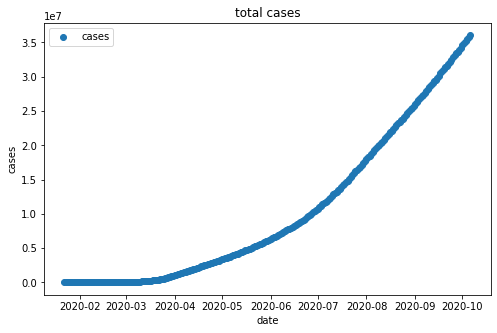

In [4]:
"""
Helper functions for Corona data.

Note: scrapping algo made by @author: pdayal
"""
import sys
import requests
import json
import re
import datetime

import bs4
import numpy as np

#
# Helper Functions
#

def __guess_date(datestr):
    """
    Parses strings of the form "Jan30" to python dates with year 2020.
    """
    for fmt in ["%b%d", "%b %d"]:
        try:
            return datetime.datetime.strptime(datestr+"-2020", fmt+"-%Y")
        except:
            pass
    return datetime.datetime(2020, 1, 1, 0, 0)

def get_corona_data():
    """
    returns a list of dictionaries with various corona data each of the form:
    table = {
        "name": "table name",
        "title": "table title",
        "subtitle": "table subtitle",
        "x": ["Jan01", "Jan02", "Jan03", "Jan04", "Jan05"],
        "series": [
            {
                "name": "name for this line",
                "values": [1, 2, 4, 8, 16]
            }
        ]
    }
    """
    url = "https://www.worldometers.info/coronavirus/coronavirus-cases/"
    html = bs4.BeautifulSoup(requests.get(url).text, "html.parser")

    get_table = re.compile("Highcharts.chart\((.*?),(.*?)\);")
    add_quotes = re.compile("([a-zA-Z0-9]+):")
    remove_inner_quotes = re.compile("'([^'\"]*)\"?([a-zA-Z0-9]*)\"?(:?[^']*)'")
    remove_last_comma = re.compile(",\s*\]")
    remove_last_comma2 = re.compile(",\s*\}")
    tables = list()
    for tag in html.findAll("script"):
        text = tag.text
        if not text:
            text = tag.string
        if not text:
            text = ("").join(tag.contents)
        if not text:
            text = str(tag)
        if "Highcharts.chart(" in text:
            match = get_table.search(text.replace("\n",""))
            name = match.group(1)
            name = name.replace("'","")
            try:
                datastr = match.group(2)
                datastr = datastr.replace("d\\'Ivoire", "dIvoire")
                jstr = add_quotes.sub("\"\\1\":", datastr)
                jstr2 = remove_inner_quotes.sub("'\\1\\2\\3'", jstr)
                jstr2 = remove_inner_quotes.sub("'\\1\\2\\3'", jstr2)
                jstr2 = remove_inner_quotes.sub("\"\\1\\2\\3\"", jstr2)
                jstr2 = jstr2.replace("'", '"')
                jstr3 = remove_last_comma.sub("]", jstr2)
                jstr3 = remove_last_comma2.sub("}", jstr3)
                data = json.loads(jstr3)

                if "xAxis" not in data:
                    continue
                xdata = data["xAxis"]["categories"]
                xdata = [__guess_date(datestr) for datestr in xdata]

                series = list()
                for line in data["series"]:
                    series.append({"name":line["name"], "values":line["data"]})

                tables.append({
                    "name": name,
                    "title": data["title"]["text"],
                    "subtitle": data["subtitle"]["text"],
                    "x": xdata,
                    "series": series
                })
            except Exception as e:
                msglen = 148 - len(name)
                errmsg = str(e)
                longmsg = len(errmsg) > msglen-3
                errmsg = errmsg[:msglen]
                if longmsg:
                    errmsg = errmsg[:-3] + "..."
                print(f"warning ({name}):", errmsg, file=sys.stderr)
    return tables

def save_tables(fstr, tables):
    """
    save corona data to a file
    """
    jan1 = datetime.datetime(2020,1,1)
    tabs = list()
    # deep copy of tables
    for t in tables:
        tab = dict()
        for key in t:
            tab[key] = t[key]
        tab["x"] = [(d - jan1).days for d in t["x"]]
        tabs.append(tab)

    # write tab to file with ints as dates
    with open(fstr, "w") as f:
        json.dump(tabs, f, indent=2)

def load_tables(fstr):
    """
    load in a list of tables of corona data from the name of a file
    """
    # read file to tables with ints as dates
    with open(fstr, "r") as f:
        tables = json.load(f)

    # turn into dates using jan1 as t=0
    jan1 = datetime.datetime(2020,1,1)
    for t in tables:
        t["x"] = [jan1 + datetime.timedelta(days=d) for d in t["x"]]

    return tables

if __name__ == '__main__':
    tables = get_corona_data()
    #tables = load_tables("corona.dat")

    # show available data tables
    for t in tables:
        print(f"{t['name']} - {t['title']}")

    # pick the table with given name
    TABLE_NAME = "coronavirus-cases-linear"
    table = next(filter(lambda t: t["name"] == TABLE_NAME, tables))

    # print some of the table data
    y = table["series"][0]["values"]
    print(table["title"])
    print(np.array(y))

    #save_tables("corona.dat", tables)
    
    
#first part: daily total cases
# get total cases data
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

TABLE_NAME = "coronavirus-cases-linear"
table = next(filter(lambda t: t["name"] == TABLE_NAME, tables))
x = table["x"]
y = np.array(table["series"][0]["values"])


#Plot total case figure
plt.figure(figsize=(8,5))
plt.plot_date(x,y,label='cases')
plt.xlabel('date')
plt.legend(loc='upper left')
plt.title('total cases')
plt.ylabel('cases')
plt.show()







print diagonals of cov matrix [1.59257530e+07 8.39674610e+00 1.77794198e+01]

y = A e^(-1/2*(x-mu)^2/s^2)
A=  288548.26410431426  +/-  3990.708330242075
s=  90.14293911574535  +/-  2.8977139431023637
mu=  213.69404370842418  +/-  4.216564933839924


plotting data for daily increase:


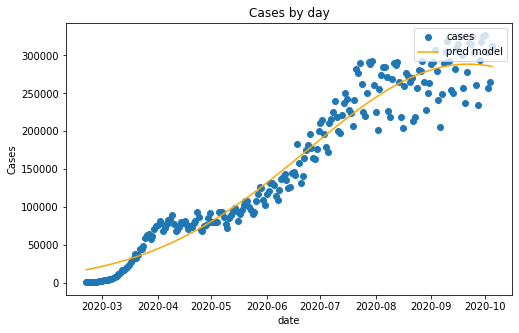



 carrying capacity:  9094929.295271128
plotting the data with extrapolation


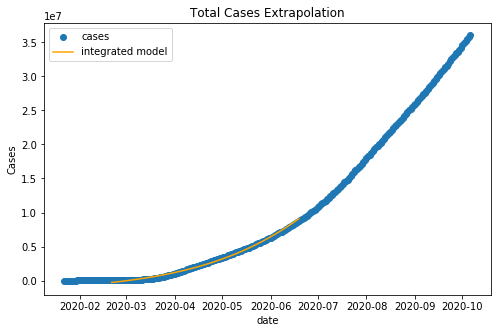

In [5]:
#Second part: Cases daily increase

x2 = list(x) 
y2 = list(y)

# igonre first 30 datapoints 

offsetx = 30
x2 = x2[offsetx::]
y2 = y2[offsetx::]

#transform dates to counter
delta=x2[-1]-x2[0]
fitx2 =np.arange(delta.days)

#create derivative
y_der=[]
for i in range(len(y2)-1):
    y_der.append((y2[i+1]-y2[i]))

#fit the curve
curve = lambda x, A, s, mu: A * np.exp(-0.5*np.square(x-mu)/s**2)
popt,pcov = curve_fit(curve,fitx2,y_der)

#printing the optimal parameters and the covariance matrix diagonal
print("print diagonals of cov matrix",np.diag(pcov))
A =popt[0]
s =popt[1]
mu =popt[2]
fity2 = curve(fitx2,*popt)

print("\ny = A e^(-1/2*(x-mu)^2/s^2)")
print("A= ",A," +/- ", np.sqrt(pcov[0][0]))
print("s= ",s," +/- ", np.sqrt(pcov[1][1]))
print("mu= ",mu," +/- ", np.sqrt(pcov[2][2]))
print("\n\nplotting data for daily increase:")
x2.pop()

#plot our data and approximation
plt.figure(figsize=(8,5))
plt.plot_date(x2,y_der,label='cases')
plt.plot_date(x2,fity2,'b-',color='orange',label="pred model")
plt.xlabel("date")
plt.ylabel('Cases')
plt.title("Cases by day")
plt.legend(loc='upper right')
plt.show()

#Part 3: extrapolate data, make predictions
from scipy import integrate

#transform date to counter
x3 = [x2[0] + datetime.timedelta(days=i) for i in range(120)]
delta2=x3[-1]-x3[0]
fitx3 =np.arange(delta2.days+1)

#extract trapezoid data

y_trap=integrate.cumtrapz(y_der,fitx2)
y_trap=np.append(y_trap,y[-1])

#fitting Sigmoid 
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

p0 = [max(y_trap), np.median(fitx3),1,min(y_trap)] 

popt, pcov = curve_fit(sigmoid, fitx2, y_trap,p0)


#Extrapolate and fit prediction
fity3 = sigmoid(fitx3,*popt)
print("\n\n carrying capacity: ",np.max(fity3))
print("plotting the data with extrapolation")

#Plot actual data and approximation, prediction included
plt.figure(figsize=(8,5))
plt.plot_date(x,y,label='cases')
plt.plot_date(x3,fity3,'b-',color='orange',label="integrated model")
plt.xlabel("date")
plt.ylabel('Cases')
plt.title("Total Cases Extrapolation")
plt.legend(loc='upper left')
plt.show()




